On 2018, Kaggle launched a competition in association with Jigsaw/Conversation AI to classify toxic comments. The original competition can be viewed [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). A toxic comment is a comment that is rude, disrespectful or otherwise likely to make someone leave a discussion. The goal of that competition was to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

However, the models developed in that competition unfortunately associated the targetted group with toxicity, i.e. "gay". For example, a comment like "I am a gay woman" would be classified as toxic. This happened as the examples of identities associated with toxicity outnumbered neutral comments regarding the same identity.

Therefore, the same team launched a new competition to recognize unintended bias towards identities. We are asked to use a dataset labeled with the associated identity. Let's look into the dataset and understand it first, so we can create a model that can better deal with bias.

At the time I started this notebook, I looked at the kernel https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw to have a quick start. So I want to take a moment to thank the Author for the kernel. The purpose of this Kernel is to walk Kaggle newbies through the process of data exploration and visualization. In this notebook, we will use Pandas to do a little bit of data wrangling and Plotly and Seaborn to visualize the result of our wrangling. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

## Section 1: Understanding The Shape of Data

In [3]:
# First, lets count how much data we have!
train_len, test_len = len(train_df.index), len(test_df.index)
print(f'train size: {train_len}, test size: {test_len}')

train size: 1804874, test size: 97320


If you want to understand each of the field, it is a good idea to read the data section of the Kaggle competition (https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). Let's take a couple of minutes to read this section first.

In [4]:
# also, lets take a quick look at what we have 
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
# its always a good idea to count the amount of missing values before diving into any analysis
# Lets also see how many missing values (in percentage) we are dealing with
miss_val_train_df = train_df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

> As you can see from the table above, a large portion of the data is missing the identity tag. However, as the number is the same for the tags, I assume that the data is complete for the part which has identity tags.

## Section 2: Understanding Toxic Comments Per Identity 

Now that we know a large portion of our dataset is doesn't have the group identity, (for now) we can drop it before we do any basic analysis. First simple and interesting question to answer would be which identity appears the most in the dataset. 

In [6]:
# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

In [7]:
# getting the dataframe with identities tagged
train_labeled_df = train_df.loc[:, ['target'] + identities ].dropna()
# lets define toxicity as a comment with a score being equal or .5
# in that case we divide it into two dataframe so we can count toxic vs non toxic comment per identity
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]

In [8]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.where(train_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(train_labeled_df == 0, other = 1).sum()

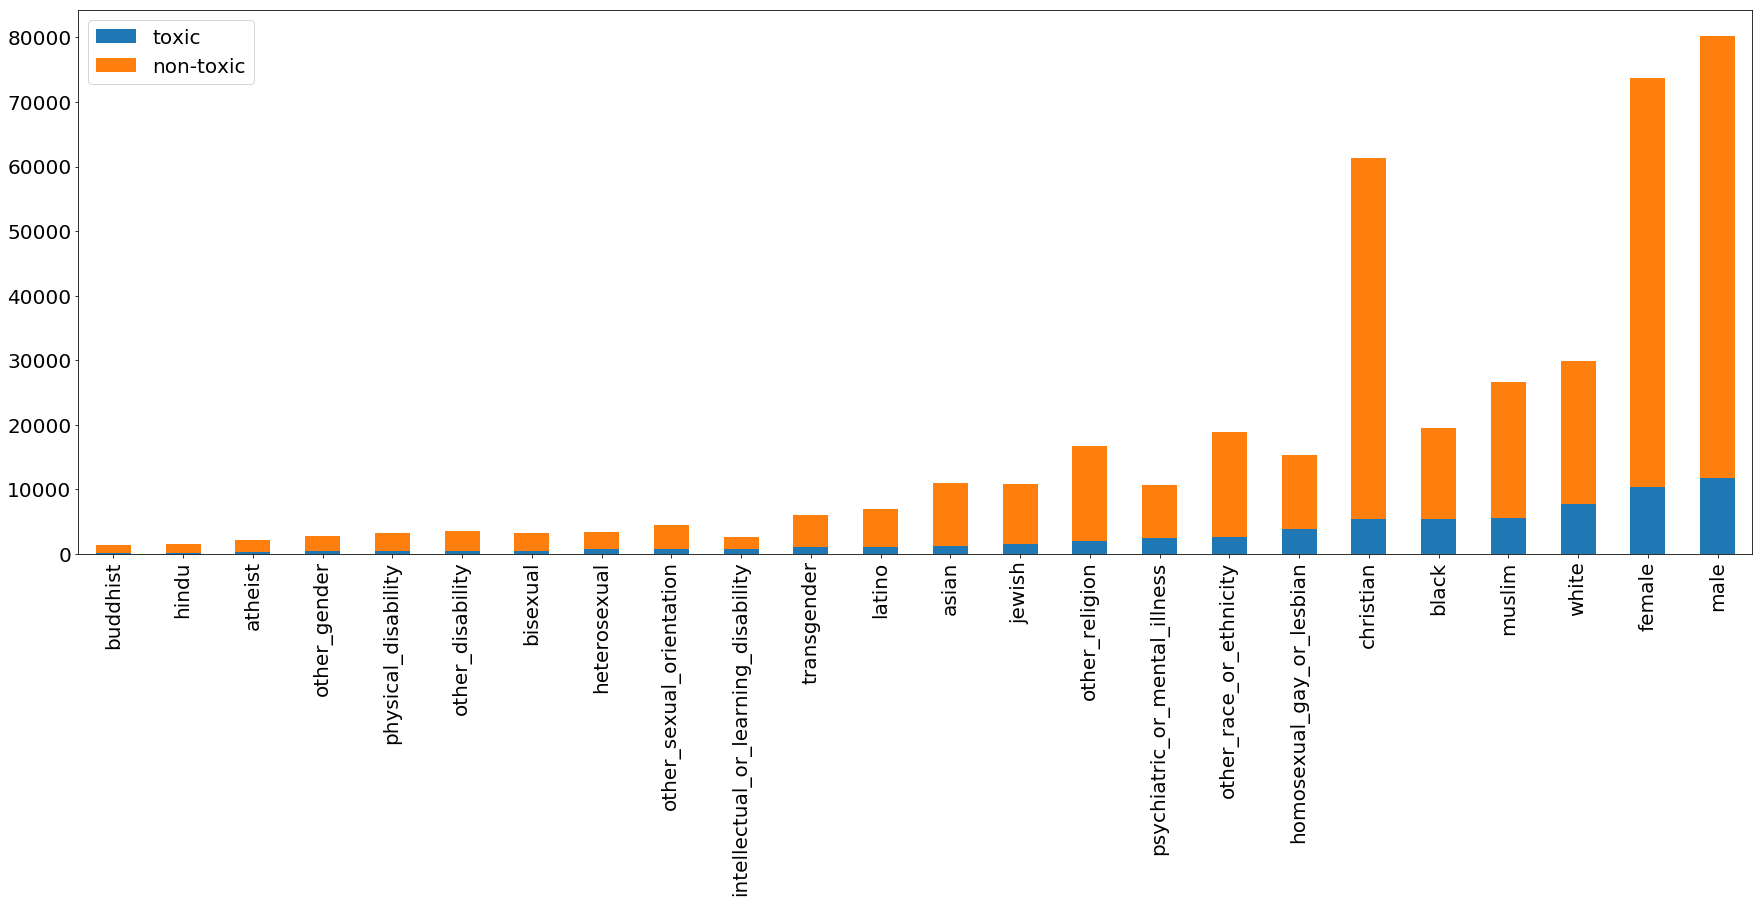

In [9]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

The diagram above is certainly one way of looking at our data. However, it is missing the complete picture because we are not using two things. First, for each example we have a score (target) of how toxic the comment is. Second, each identity also has a value between 0 to 1 to identify how much they have been targeted. We can use this two aspects to our advantage and see which identities are more frequently related to toxic comments.

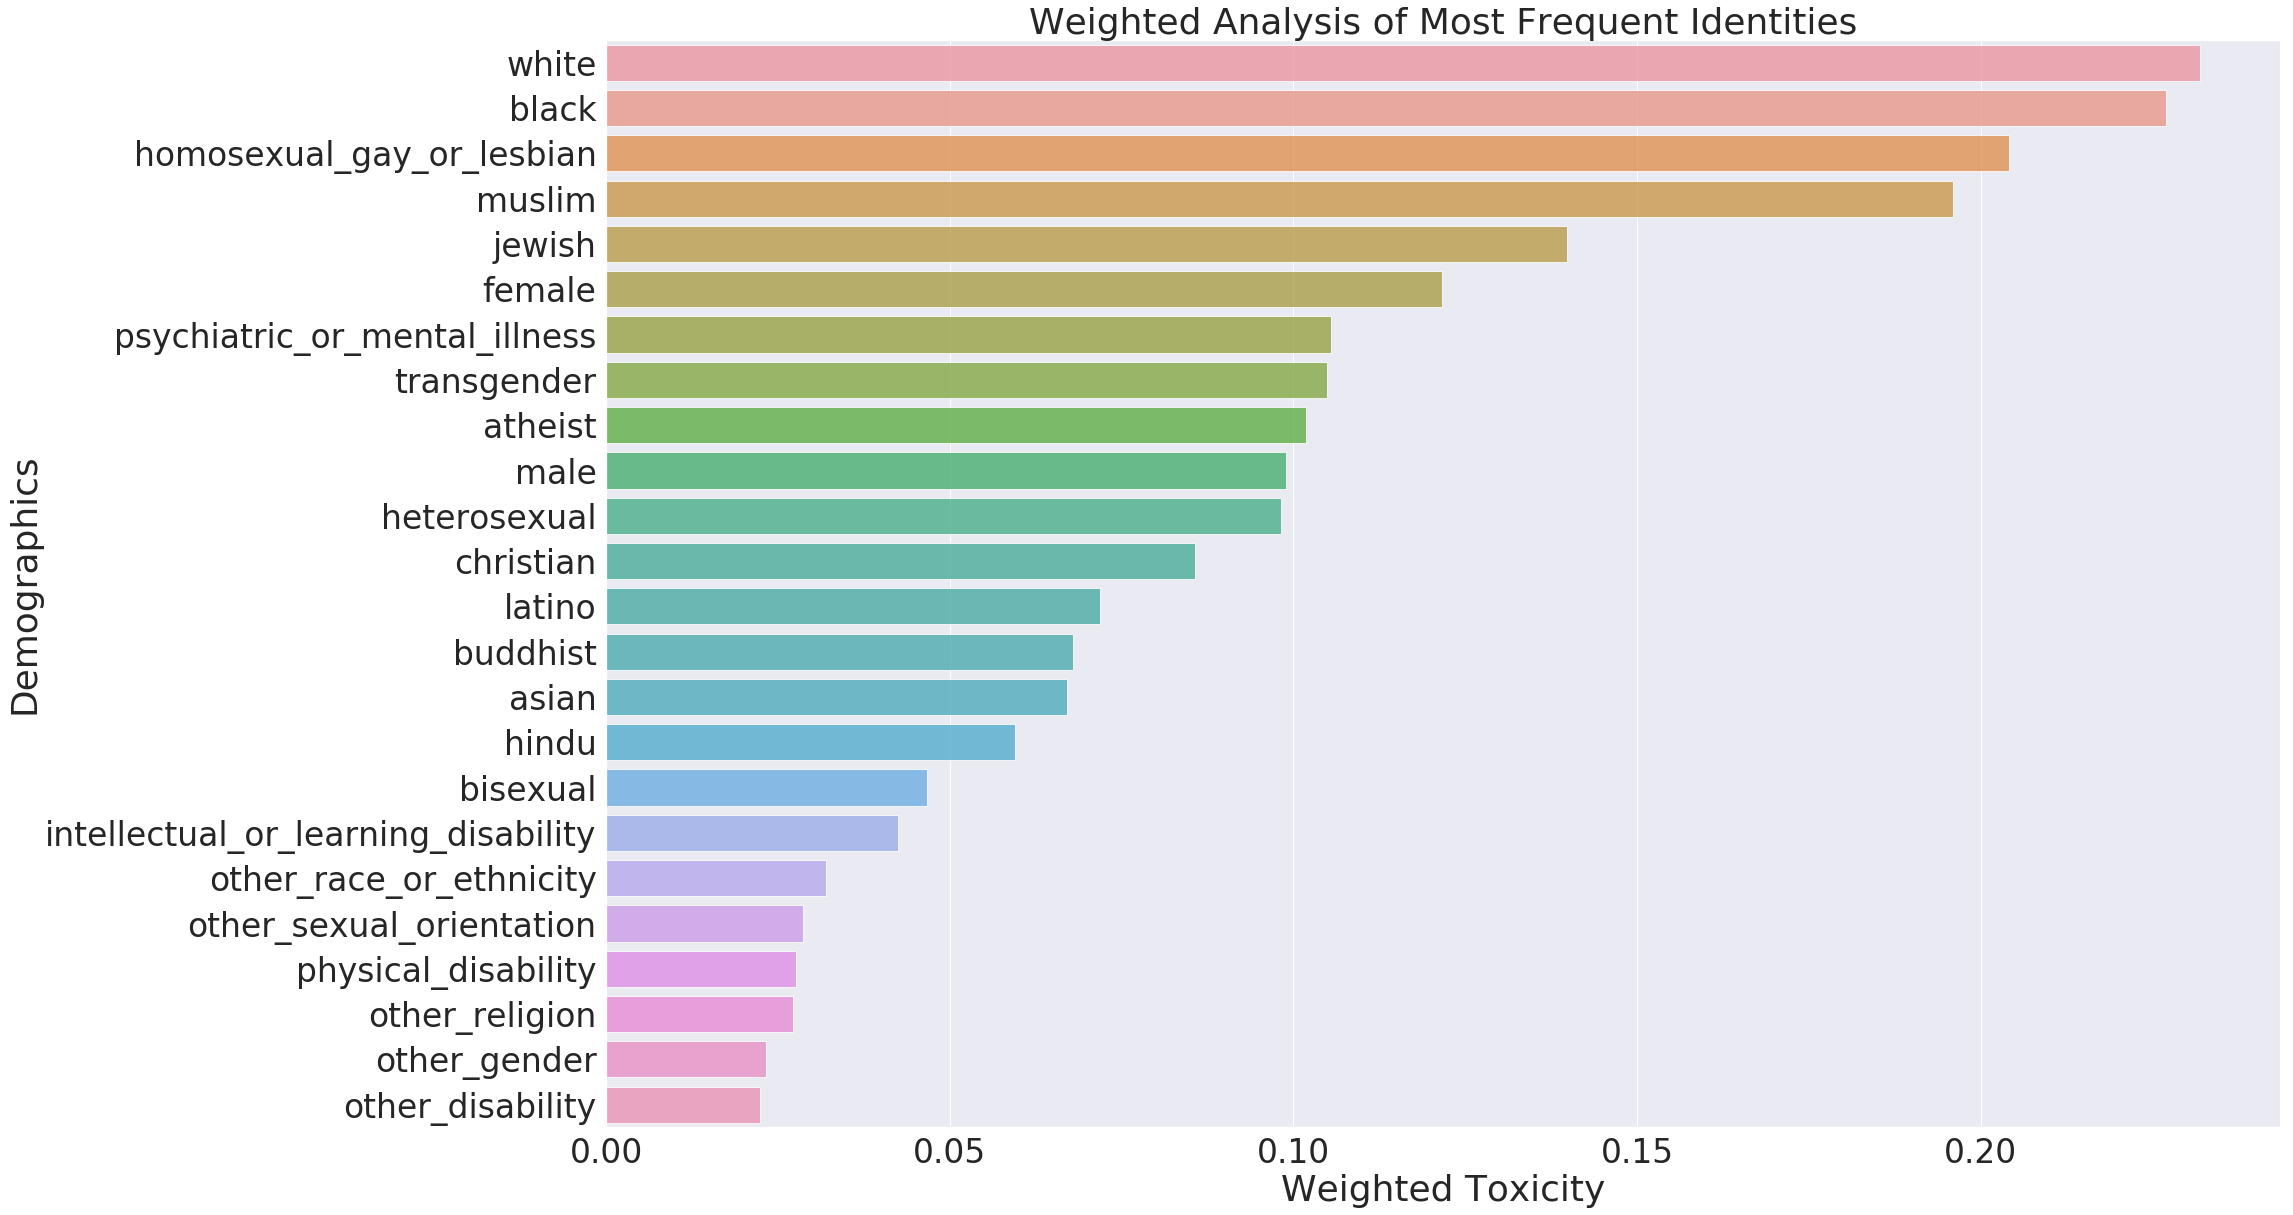

In [10]:
# First we multiply each identity with the target
weighted_toxic = train_labeled_df.iloc[:, 1:].multiply(train_labeled_df.iloc[:, 0], axis="index").sum() 
# changing the value of identity to 1 or 0 only and get comment count per identity group
identity_label_count = train_labeled_df[identities].where(train_labeled_df == 0, other = 1).sum()
# then we divide the target weighted value by the number of time each identity appears
weighted_toxic = weighted_toxic / identity_label_count
weighted_toxic = weighted_toxic.sort_values(ascending=False)
# plot the data using seaborn like before
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values , y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxicity')
plt.title('Weighted Analysis of Most Frequent Identities')
plt.show()

As we can see from the graph above, the two race based identities (White and Black) and religion based identities (Muslim and Jews) are heavily associated with toxic comments. 

## Section 3: Time Series Analysis of Comments Made
The dataset also has a 'created_date' field, which tells us when the comment was made. We can use this field to do some time series analysis. In this section, we will also use plotly for simplifying our visualization needs.**

In [11]:
# lets take the dataset with identitiy tags, created date, and target column
with_date_df = train_df.loc[:, ['created_date', 'target'] + identities].dropna()
# next we will create a weighted dataframe for each identity tag (like we did before)
# first we divide each identity tag with the total value it has in the dataset
weighted_df = with_date_df.iloc[:, 2:] / with_date_df.iloc[:, 2:].sum()
# then we multiplty this value with the target 
target_weighted_df = weighted_df.multiply(with_date_df.iloc[:, 1], axis="index")
# lets add a column to count the number of comments
target_weighted_df['comment_count'] = 1
# now we add the date to our newly created dataframe (also parse the text date as datetime)
target_weighted_df['created_date'] = pd.to_datetime(with_date_df['created_date'].apply(lambda dt: dt[:10]))
# now we can do a group by of the created date to count the number of times a identity appears for that date
identity_weight_per_date_df = target_weighted_df.groupby(['created_date']).sum().sort_index()

In [12]:
# lets group most of the identities into three major categories as follows for simplified analysis
races = ['black','white','asian','latino','other_race_or_ethnicity']
religions = ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'jewish','other_religion']
sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

Text(0, 0.5, 'Weighted Toxic Score')

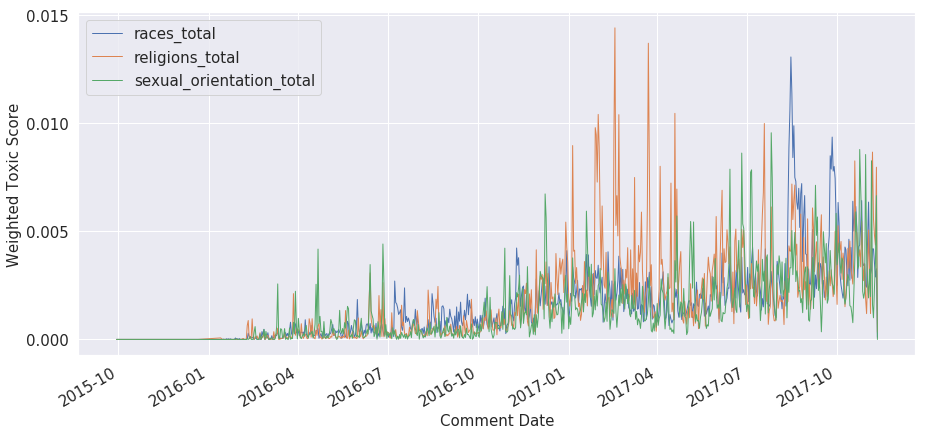

In [13]:
# lets create a column to aggregate our weighted toxicity score per identity group
identity_weight_per_date_df['races_total'] = identity_weight_per_date_df[races].sum(axis=1)
identity_weight_per_date_df['religions_total'] = identity_weight_per_date_df[religions].sum(axis=1)
identity_weight_per_date_df['sexual_orientation_total'] = identity_weight_per_date_df[sexual_orientation].sum(axis=1)
# and then plot a time-series line plot per identity group
identity_weight_per_date_df[['races_total', 'religions_total', 'sexual_orientation_total']].plot(figsize=(15,7), linewidth=1, fontsize=15) 
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Weighted Toxic Score', fontsize=15)

At first sight, what a sad graph to look at. First of all, there are many many spikes in our dataset, so we should zoom into each identity per group to see more. Furthermore, we notice a trend of more toxic messages as time goes by. What a depressing sight :( However, we should keep in mind that the distribution of data over the timeline is probably skewed. Lets check it out.

Although there are many spikes in this dataset, there are two that really stands out to me.

1. There huge spike of toxic comments against religion between 2017-01 to 2017-04. This might be because Donald Trump took office in January 2017, and during this time both people were very toxic toward various religions.

2. There is a big spike on toxicity towards races in the middle period between 2017-07 to 2017-10. I did a search on [Goolge Trends on topic that was probabily hot at that time, "black lives matter"](https://trends.google.com/trends/explore?date=2017-01-07%202017-12-31&geo=US&q=black%20lives%20matter). Over there we can see that there is a spike around 13th August 2017, which looks like the period we are interested in. Then I found an [aritlce](http://https://theweek.com/10things/713315/10-things-need-know-today-august-13-2017) from "The Week" that helped me understand this spike, as it summarizes all the major events from that week. At that time the "Charlottesville white nationalist rally", which probably the reason for this spike. 

It isn't my intention to go through each spike and understand what happened there. **I rather wanted to convey the point that toxicity in the comments typically seems to be triggered or an aftermath of certain events.** A little intuative and obvious, but it's always good to point out the obvious with data.


Text(0, 0.5, 'Total Comments')

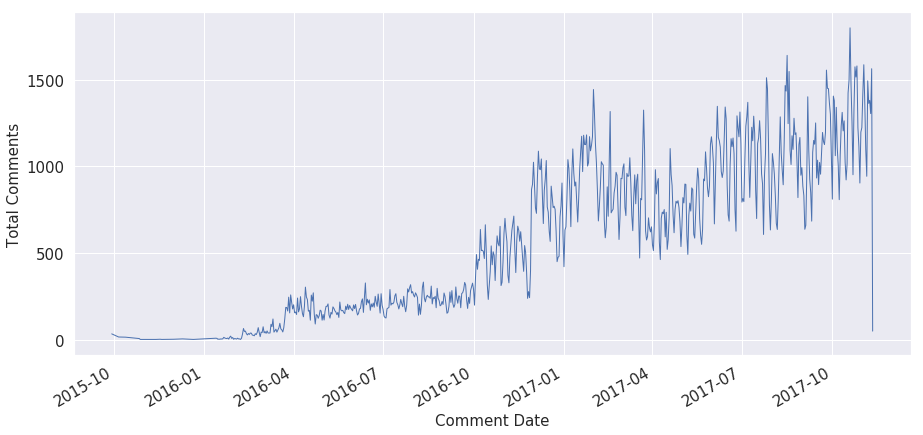

In [14]:
identity_weight_per_date_df['comment_count'].plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.xlabel('Comment Date', fontsize = 15)
plt.ylabel('Total Comments', fontsize = 15)

As we dont have an even distribution of data for our timeline, we can use the comment count to get a better relative weighted toxic score and see where the peaks are.

Text(0, 0.5, 'Relative Weighted Toxic Score')

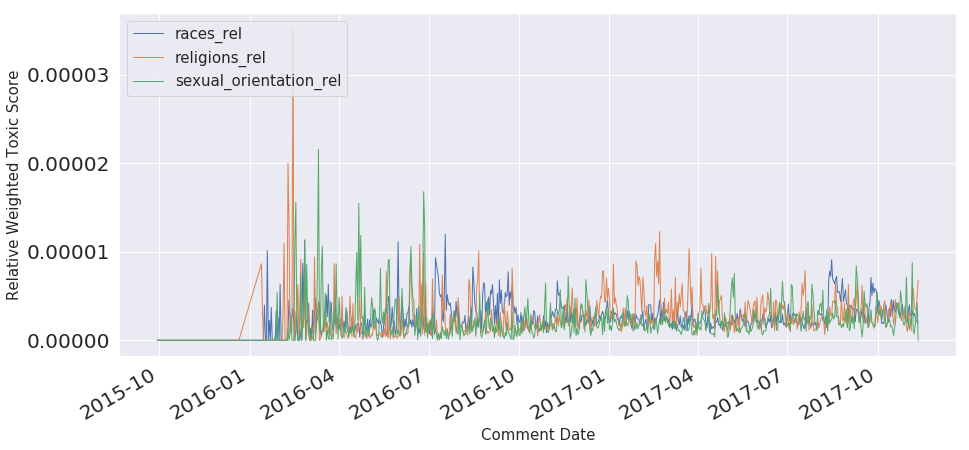

In [15]:
# lets divide by the comment count for the date to get a relative weighted toxic score
identity_weight_per_date_df['races_rel'] = identity_weight_per_date_df['races_total'] / identity_weight_per_date_df['comment_count']
identity_weight_per_date_df['religions_rel'] = identity_weight_per_date_df['religions_total'] / identity_weight_per_date_df['comment_count']
identity_weight_per_date_df['sexual_orientation_rel'] = identity_weight_per_date_df['sexual_orientation_total']  / identity_weight_per_date_df['comment_count']
# now lets plot the data
identity_weight_per_date_df[['races_rel', 'religions_rel', 'sexual_orientation_rel']].plot(figsize=(15,7), linewidth=1, fontsize=20) 
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

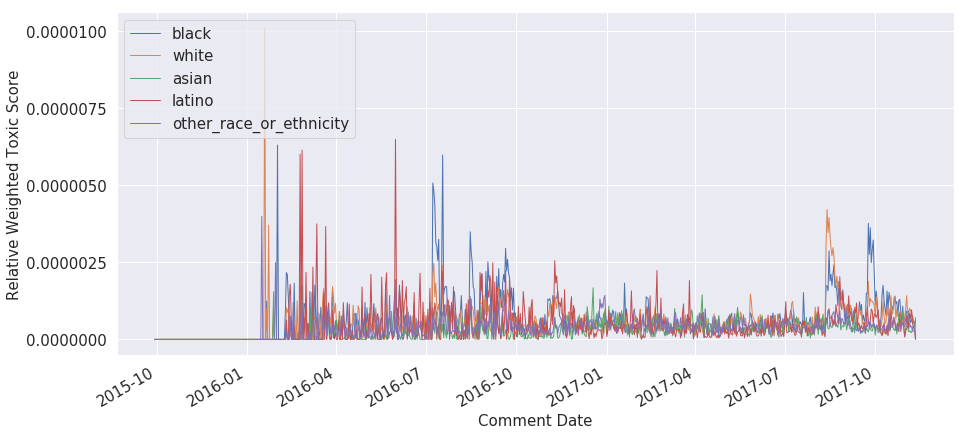

In [16]:
# lets plot relative weighted toxic score for each identity of races
identity_weight_per_date_df[races].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

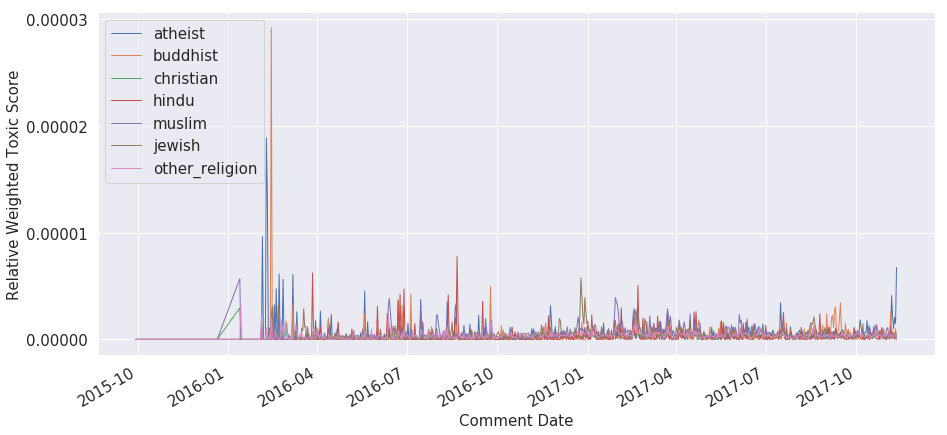

In [17]:
# lets plot relative weighted toxic score for each identity of religions
identity_weight_per_date_df[religions].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

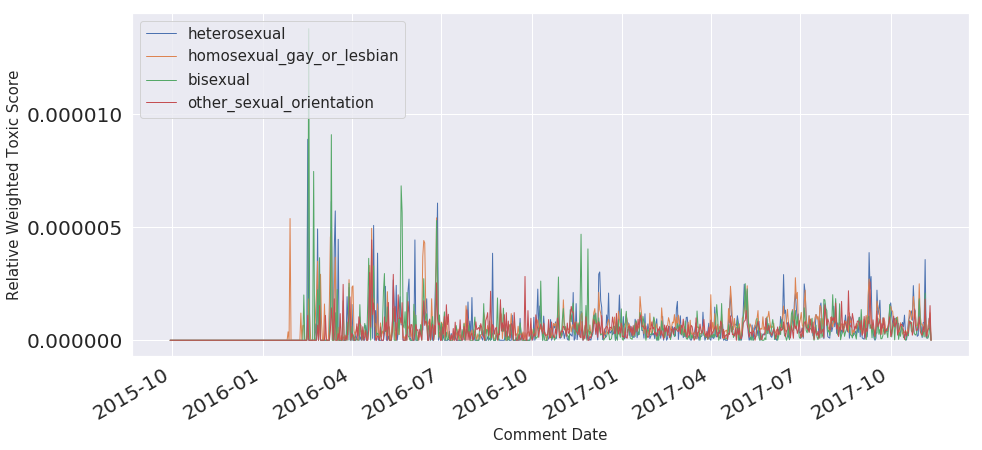

In [18]:
# lets plot relative weighted toxic score for each identity of sexual orientation
identity_weight_per_date_df[sexual_orientation].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=20)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Interesting! After looking at the visualization above, we can conclude the few following things:

* Amount of hate or toxic comments directed toward any of the group isn't constant
* The dataset is full of spikes or relative maximums
* This probably happens due to certain events that triggers hate toward a particular identity

## Section 4: Zooming Into the Peaks
As we saw in the last section, since there are so many spikes in our dataset, it is very easy to get distracted. To have a better idea we must zoom out. In this section we do that by extracting the peaks. This could be challenging, as we are not just looking for one global maximum. On the other hand, even if we sort it, we will not be able to find all the relative maximums without writing a complex algorithm to do so.

Fortunately, there is a great algorithm from **scipy** library called **'argrelextrema'** that will allow us to extract the relative maximum points from our dataset. For more details about this algorithm, check out the document section: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html

In [19]:
# lets import the algorithm
from scipy.signal import argrelextrema

Using this algorithm, we want to create a pandas dataframe to capture all the extreme points in our dataset that captures all the peak points per identity group. We will also want to do a scatter plot in the next section, and scatterplot implementation needs both values (x and y) to be numeric. So we also better create a column to represent the dates in a more numeric form. 

We can do this by taking the date of the first comment as our reference point, and counting how many days the comment was made from the first comment in our dataset. Therefore, in the end we should get a dataframe with the following columns:

| identity | created data | score | days_from_first |

In [20]:
# we will store all the different datapoints in the following dataframe
peaks_df = pd.DataFrame()

# first we loop through all the different identities we are interested in
for col in races + religions + sexual_orientation:
    # we pass the values through the algorithm to get an index of the rel. maximums 
    _max_index = argrelextrema(identity_weight_per_date_df[col].values, np.greater, order=15)
    # we use the index returned to create a dataframe of the values for those index. in this case 
    # we are interested in the created date and the score, notice how the dataframe needs to be 
    # transformed because of the orientation of the arrays we started off with
    col_peaks_df = pd.DataFrame(data = [identity_weight_per_date_df.index[_max_index], identity_weight_per_date_df[col].values[_max_index]]).T
    col_peaks_df.columns = ['created_date','score']
    # we create a new column labeling the identity so we can track which peak came from which identity
    col_peaks_df['identity'] = col
    # and we keep appending to our main dataframe 
    peaks_df = peaks_df.append(col_peaks_df)
# lets set identity as our index and we are done
peaks_df = peaks_df.set_index('identity')

In [21]:
# to count the number of days from the first comment, we take our labeled data and convert the created date column
comments_with_date_df = train_df.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()
comments_with_date_df['created_date'] = pd.to_datetime(with_date_df['created_date'].apply(lambda dt: dt[:10]))
comments_with_date_df['comment_count'] = 1

In [22]:
# calculate days from first comment
first_dt = min(comments_with_date_df['created_date'].values)
last_dt = max(comments_with_date_df['created_date'].values)
peaks_df['days_from_first'] = (peaks_df['created_date'] - first_dt).dt.days

In [23]:
# here is a peak at what our peaks_df looks like
peaks_df.head()

,created_date,score,days_from_first
identity,,,
black,2016-02-10 00:00:00,0.000138761,134
black,2016-03-28 00:00:00,0.000249878,181
black,2016-05-21 00:00:00,0.000300618,235
black,2016-07-08 00:00:00,0.00146737,283
black,2016-08-15 00:00:00,0.000894331,321


Now that we have the peaks, lets visualize it. Scatter plot is typically used to show if there is a correlation between two variables. However, in this case, we can also use scatterplot to draw the relative maximums as descrete points. The nice thing about a scatter plot is that we can visualize a third variable as the size of the point. Let's take advantage of this and use the number of comments made as the size of the relative maximum points.

In [24]:
# lets create a function that returns the peaks dataframe for a given identity
# we also want to get the number of toxic comments made against that identity in the dataframe
def get_identity_peaks_df(identity, peaks_df, comments_with_date_df):
    # select subset and sort
    identity_peaks_df = peaks_df[peaks_df.index==identity].sort_values(by='score', ascending=False)
    # change the score type to float
    identity_peaks_df['score'] = identity_peaks_df.score.astype(float)
    # use created date as the index so we can join over in later step
    identity_peaks_df = identity_peaks_df.set_index('created_date')
    # calculate how many toxic comments were made targetting the given identity group
    identity_comment_count_df = comments_with_date_df[comments_with_date_df[identity] > 0][['created_date','comment_count']].groupby('created_date').sum()
    # do an inner join to also get the total number of comments made that day for the given identity
    identity_peaks_df = identity_peaks_df.join(identity_comment_count_df)
    return identity_peaks_df

In [25]:
# to make our scatter plot more presentable we will set the max and min of our y axis
y_lim_min = peaks_df['score'].max() + peaks_df['score'].max() / 3 # adding a little bit head room on y axis
y_lim_max = peaks_df['score'].min() 

In [26]:
# now lets write a function that draws the scatter plot for a given identity
def identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max):
    x = identity_peaks_df['days_from_first'].values
    y = identity_peaks_df['score'].values
    size = identity_peaks_df['comment_count'].values
    label = identity_peaks_df['comment_count'].index
    plt.figure(figsize=(15,7))
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.scatter(x, y, s=size, label=label)
    plt.ylim(y_lim_max, y_lim_min)
    axis_font = {'fontname':'Arial', 'size':'14'}
    plt.title('Relative Maximums - Targeted Against '+ identity.capitalize() +' Identity', fontsize=15)
    plt.xlabel('Comment Date', fontsize=15)
    plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Now we are ready to plot each relative maximums per identity group. However, lets only look at top 5 for now. If you remember the horizontal bar plot we did at the start of our tutorial (second graph from the top), you can see that the identities that are most frequently targeted are white, black, homosexual_gay_or_lesbian, muslim, and jewish.

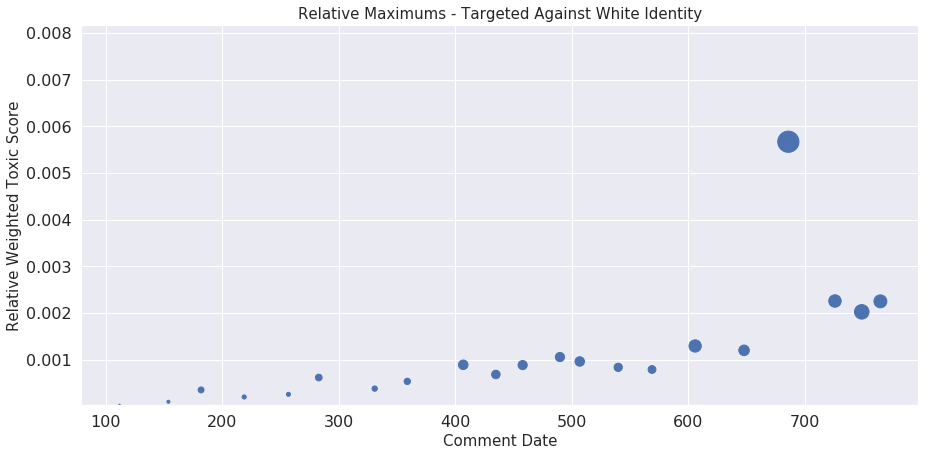

In [27]:
identity = 'white'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

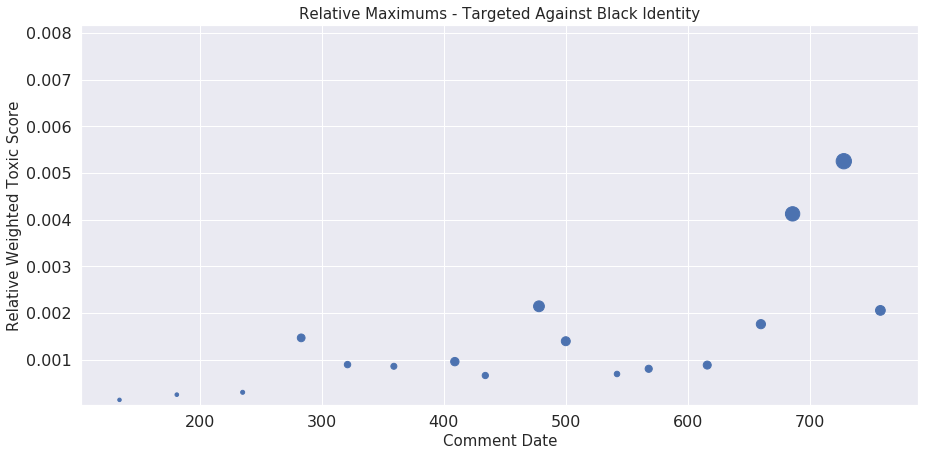

In [28]:
identity = 'black'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

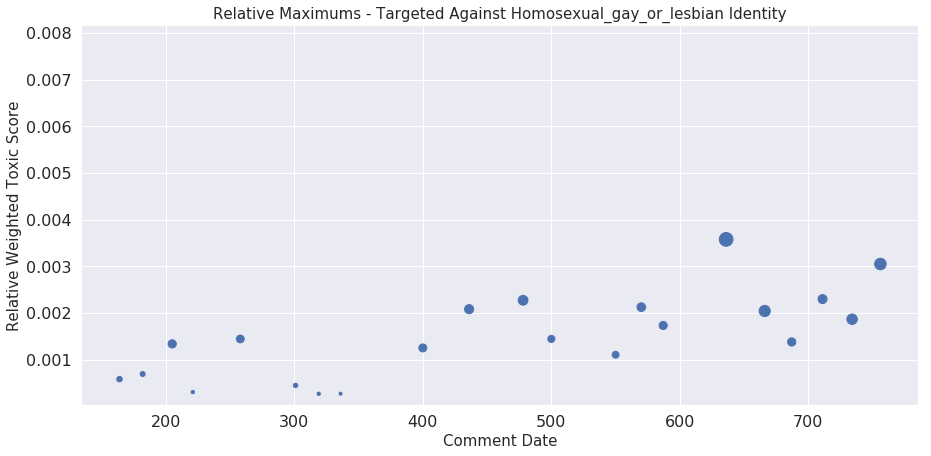

In [29]:
identity = 'homosexual_gay_or_lesbian'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

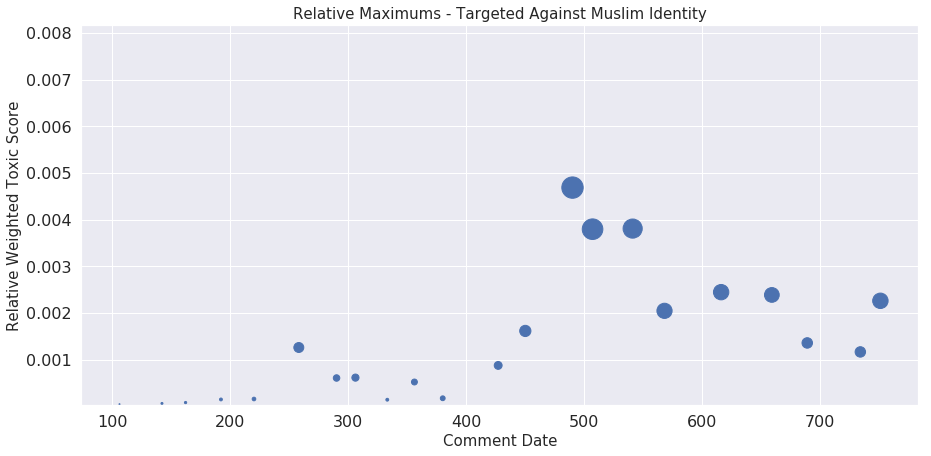

In [30]:
identity = 'muslim'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

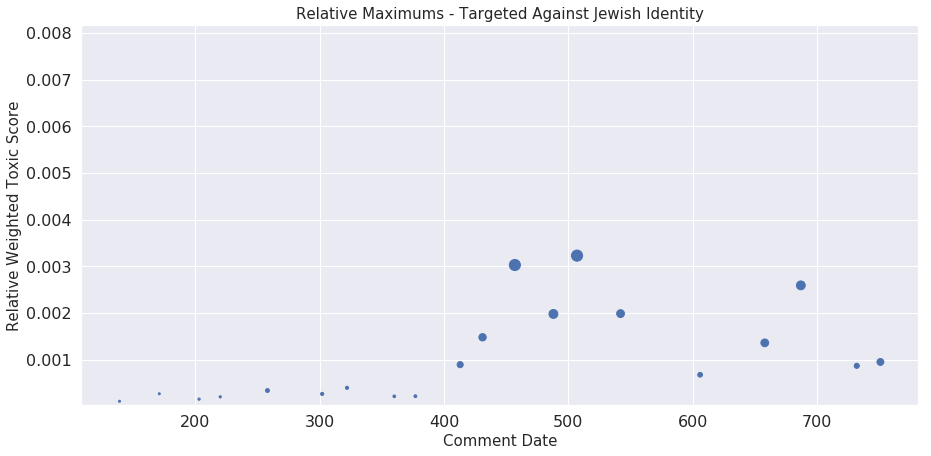

In [31]:
identity = 'jewish'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

This is great! I will write down the analysis later! Meanwhile, if you have a great observation, write it down in the comment section =) 

## Section 5: Correlation and Heatmap of Identities

To better understand the dataset, we need to look at the correlation between each identities. Thus, in this section we will calculate the correlation between each of the identities and see if identities are often mentioned together. We are also interested to know which identities are frequently mentioned (or not mentioned) together. Understanding correlation for a large number of columns would be very difficult without visualization. However, this task is very simple once you draw a heatmap.

To do this we will use Seaborn, a library that wraps around matplotlib and makes plotting easier to use. The full documentation for plotting a heatmap for correlation matrix can be found in the [documentation](https://seaborn.pydata.org/examples/many_pairwise_correlations.html).

In [32]:
# Lets import seaborn
import seaborn as sns

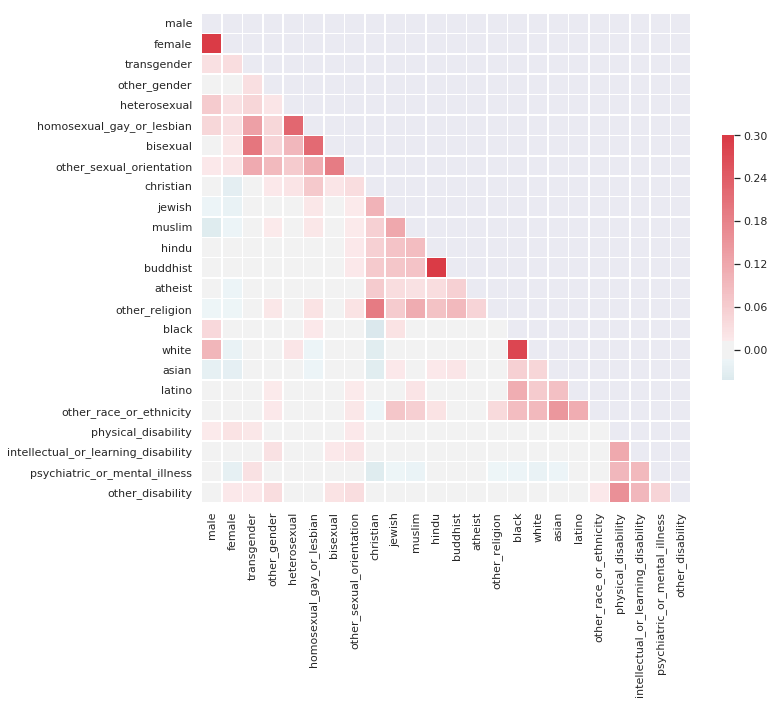

In [33]:
# Compute the correlation matrix
corr = comments_with_date_df[identities].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap plot of the correlation between the identities is very insightful. I will summarize my observations below. As always, if you see something interesting please mention it to me in the comment section.
* It is interesting to see that strong correlations form triangular area at the edge of diagonal. 
* This basically means that there is a strong correlation between the groups of the identity (gender, religion, races, disabilities). This means, the comments where male identity is the target, female identity is also very likely to be the target.
* In another words, in toxic and non-toxic comments, **people tend to make it about one group vs another quiet frequently**.

## Section 6: Looking At Word Clouds

Tag cloud or word cloud is an effective way to visualize text data. Also, to clear the clutter and focus better, I will only use the comments from the peaks per identity and create word cloud of the most frequent words. To do this we will use a popular python library called WordCloud. We will also use NLTK to take stop words (like the, it, and so on) out of our WordCloud.

There is a really nice tutorial on DataCamp that teaches you about some of the basic and advanced features of using WordCloud. Check it out if you are interested to learn more: https://www.datacamp.com/community/tutorials/wordcloud-python

In [34]:
# import wordcloud
from wordcloud import WordCloud
# import NLTK mainly for stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# we will write a simple function to generate the wordcloud per identity group
def generate_word_cloud(identity, toxic_comments, non_toxic_comments):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    # create toxic wordcloud
    wordcloud_toxic = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(toxic_comments)
    # create non-toxic wordcloud
    wordcloud_non_toxic = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(non_toxic_comments)
    # draw the two wordclouds side by side using subplot
    fig = plt.figure(figsize=[15,5])
    fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_toxic, interpolation="bilinear")
    plt.axis("off")
    fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_non_toxic, interpolation="bilinear")
    plt.axis("off")
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Word Cloud - {} Identity'.format(identity), size = 16)
    plt.show()

In [36]:
# this function returns a tuple (toxic comments, non toxic comments) for the peaks
def get_comments(identity, identity_peaks_df):
    # create an empty array to return comments
    toxic_comments, non_toxic_comments = np.array([]), np.array([])
    # go over all the dates and grab the relevant comments for the given identity
    for dt in identity_peaks_df.index:
        # get the toxic comments
        comments_dt_df = comments_with_date_df[(comments_with_date_df['created_date'] == dt) \
                                               & (comments_with_date_df[identity] > 0) \
                                               & (comments_with_date_df['target'] >= .5)]
        toxic_comments = np.append(toxic_comments, comments_dt_df['comment_text'].values)
        
        # get the non toxic comments
        comments_dt_df = comments_with_date_df[(comments_with_date_df['created_date'] == dt) \
                                               & (comments_with_date_df[identity] > 0) \
                                               & (comments_with_date_df['target'] < .5)]
        non_toxic_comments = np.append(non_toxic_comments, comments_dt_df['comment_text'].values)
    
    return (toxic_comments, non_toxic_comments)

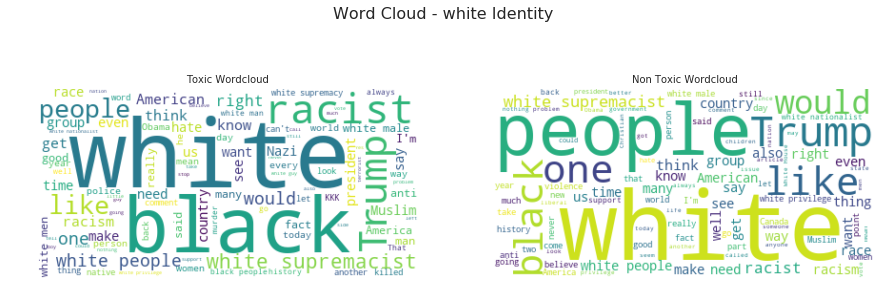

In [37]:
# lets draw the wordcloud for white identity
identity = 'white'
# get the peaks for the given identity
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
# get the comments for the given identity for the peaks
identity_comments = get_comments(identity, identity_peaks_df)
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

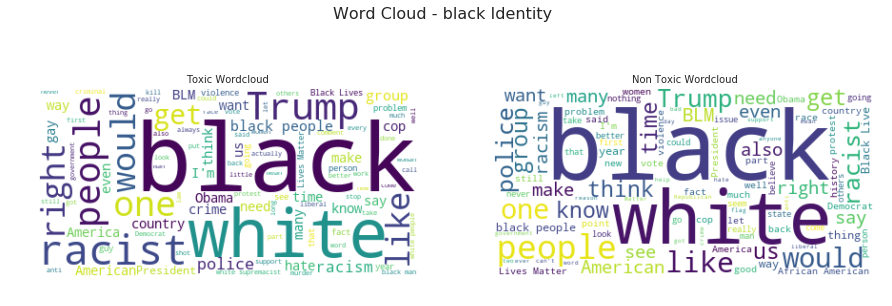

In [38]:
# like white identity, lets draw the wordcloud for the other top identities
identity = 'black'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

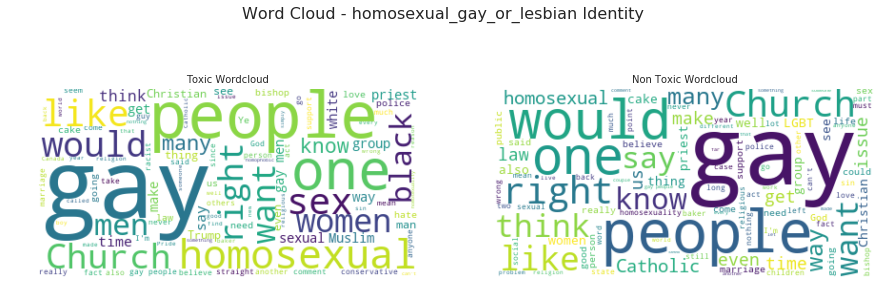

In [39]:
identity = 'homosexual_gay_or_lesbian'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

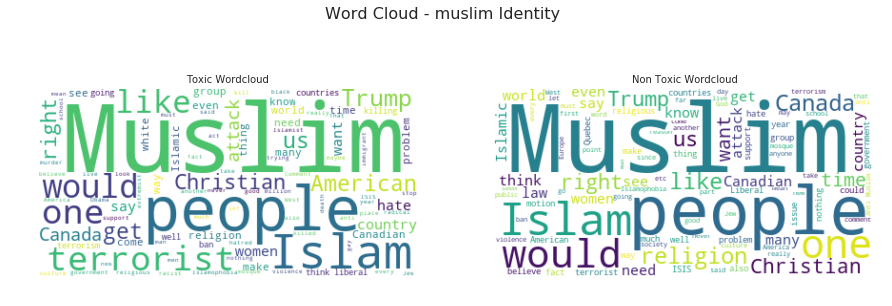

In [40]:
identity = 'muslim'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

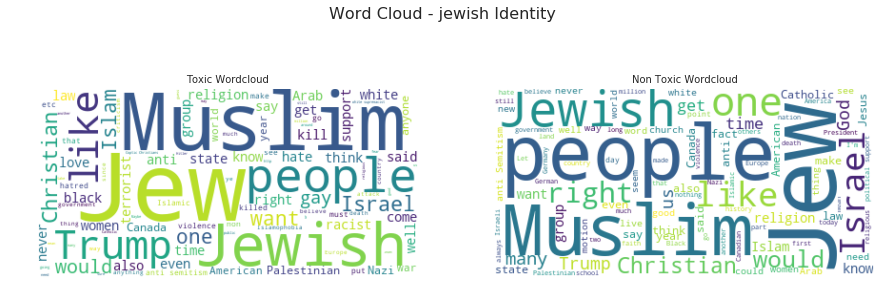

In [41]:
identity = 'jewish'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_comments = get_comments(identity, identity_peaks_df)
toxic_comments = ' '.join(identity_comments[0])
non_toxic_comments = ' '.join(identity_comments[1])
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

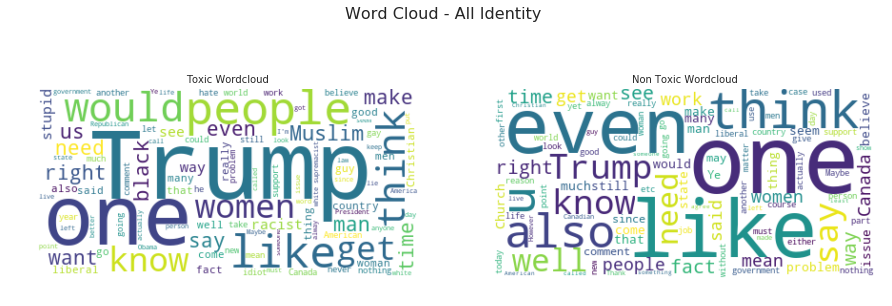

In [42]:
toxic_comments = comments_with_date_df[comments_with_date_df['target'] >= .5]['comment_text'].values
non_toxic_comments = comments_with_date_df[comments_with_date_df['target'] < .5]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
non_toxic_comments = ' '.join(non_toxic_comments)
generate_word_cloud('All', toxic_comments, non_toxic_comments)

The wordcloud above is really interesting. Looking at it, I have made the following observations:
1. Although the sentiment within the sentences (probably) varies in toxic and non-toxic comments, looking at it from top word frequencies, the differences are not that big.
2. Between comments about White and Black identity, there is a huge overlap!
3. Comments towards homosexual have more unique set of words (as imagined) from the other identity groups. However, between toxic and non-toxic comment there isn't a big variation in terms of the high frequenty words.
4. For comments about Jewish identity, the word Muslim appears frequently. After reviewing a lot of the samples of such comments I noticed that a large number of comments about Jewish identity is toxic towards Muslim identity.
5. Ironically, Trump is a very frequent common topic of discussion in toxic and non-toxic comments. However, frequency of Trump appearing is more in toxic comments. "Trump" or "Trump Supporters" could be a identitity in itself =)

Do you see other interesting patterns in the visualization above? Did I make a mistake? Can I do something better? Write them down in the comment section if possible :)

## Section 7: Emojis

Emojis are quickly becoming more and more popular in the comment section on the internet. I have even seen people communicate only via emojis without using a single word. In this section, let's look into the frequency of emojis being used per identity group and if there is really a difference in the way emojis are used between toxic and non toxic comments. Python has a great library called emoji, that you can install using `pip install emoji --upgrade` if you don't have it.

In [43]:
import emoji
from collections import Counter
from itertools import chain

In [44]:
# we will use this simple function to process a string and return all the emojis as a list
def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

In [45]:
# createa new column to count the number of emojis per row / comment
comments_with_date_df['emoji_count'] = comments_with_date_df['comment_text'].apply(lambda x: len(extract_emojis(x)))

In [46]:
# here we will count the mean or average number of emojis for toxic and non toxic comments per identity

emoji_mean_per_identity = []

for identity in identities:
    toxic_emoji_mean = comments_with_date_df[(comments_with_date_df[identity]> 0) & (comments_with_date_df['target'] >= .5)]['emoji_count'].mean()
    non_toxic_emoji_mean = comments_with_date_df[(comments_with_date_df[identity]> 0) & (comments_with_date_df['target'] < .5)]['emoji_count'].mean()
    emoji_mean_per_identity.append([identity, toxic_emoji_mean, non_toxic_emoji_mean])

emoji_mean_per_identity_df = pd.DataFrame(emoji_mean_per_identity, columns = ['identity','toxic','non toxic']).set_index('identity')

Text(0.5, 1.0, 'Emojis usage in comments for different identities')

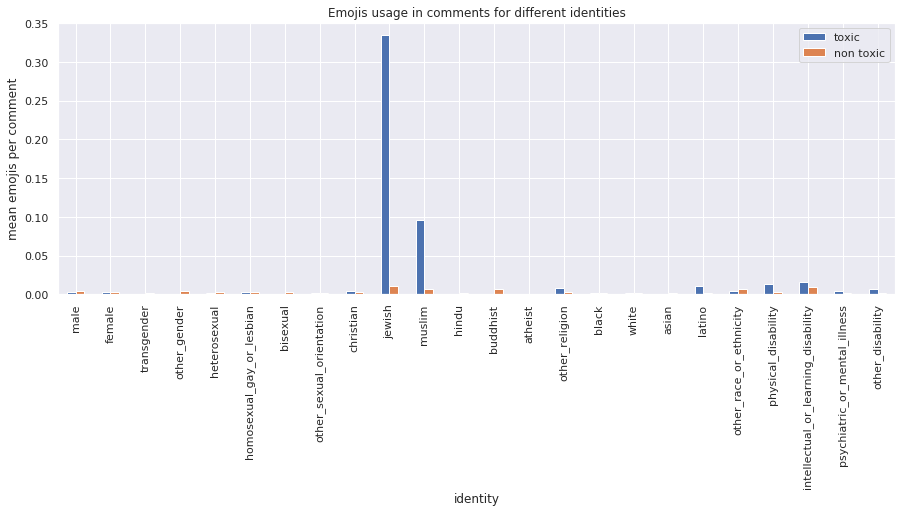

In [47]:
# now we can plot our dataframe and see what we have
emoji_mean_per_identity_df.plot.bar(figsize=(15,5))
plt.ylabel('mean emojis per comment')
plt.title('Emojis usage in comments for different identities')

Oh wow this is interesting! People seem to use emoji more frequently in toxic comments regarding muslim and jewish identity. Perhaps there are a few comments that are causing this spike, and it would be good to normalize somehow. Let's count each comment with at least one emoji and then see what is the mean.

In [48]:
# createa new column to count the number of emojis per row / comment
comments_with_date_df['uses_emoji'] = comments_with_date_df['comment_text'].apply(lambda x: 1 if len(extract_emojis(x)) > 0 else 0)

In [49]:
comment_using_emoji_per_identity = []

for identity in identities:
    toxic_emoji_mean = comments_with_date_df[(comments_with_date_df[identity]> 0) & (comments_with_date_df['target'] >= .5)]['uses_emoji'].mean()
    non_toxic_emoji_mean = comments_with_date_df[(comments_with_date_df[identity]> 0) & (comments_with_date_df['target'] < .5)]['uses_emoji'].mean()
    comment_using_emoji_per_identity.append([identity, toxic_emoji_mean, non_toxic_emoji_mean])

comment_using_emoji_per_identity_df = pd.DataFrame(comment_using_emoji_per_identity, columns = ['identity','toxic','non toxic']).set_index('identity')

Text(0.5, 1.0, 'Emojis used in comment for different identities - Normalized')

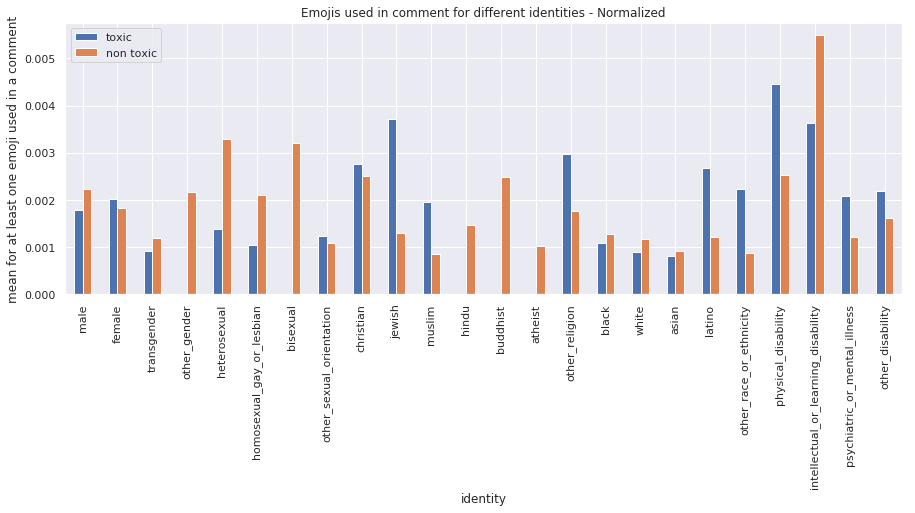

In [50]:
# now we can plot our dataframe and see what we have
comment_using_emoji_per_identity_df.plot.bar(figsize=(15,5))
plt.ylabel('mean for at least one emoji used in a comment')
plt.title('Emojis used in comment for different identities - Normalized')

This clears the picture up much better. First of all, the overall use of emoji is pretty low compared to what I see nowaydays. Furthermore, there are definetly a few comments with a rediculous number of emojis which are responsible for skewing our data in the last plot. Finally, as you can imagine; the use of emoji varies and doesn't really differentiate toxic comments and non-toxic comments.

## Section 8: Understanding Severe Toxicity 

Our primary measure of toxicity or our label is given in the target colum. Next to this target variable, we also have another label column, severe toxicity. Labeled data is an extremly valuable resource, and in this section we zoom into severe toxicity to understand if this score can be used in any way to understand our data better. To do this, we will do a boxplot of the severe toxicity for toxic and non toxic comments. 

Ps. Toxic and non Toxic comments are segregated by the definintion given (above and equal to .5 is toxic, and rest is non-toxic).

In [51]:
# take the relevant subset of our data
severe_toxicity_df = train_df.loc[ : ,['target','severe_toxicity']]

In [52]:
# make a categorical column to classify a comment toxic and non toxic
severe_toxicity_df['is_toxic'] = severe_toxicity_df['target'].apply(lambda x: 'Toxic' if x >= .5 else 'Not Toxic')

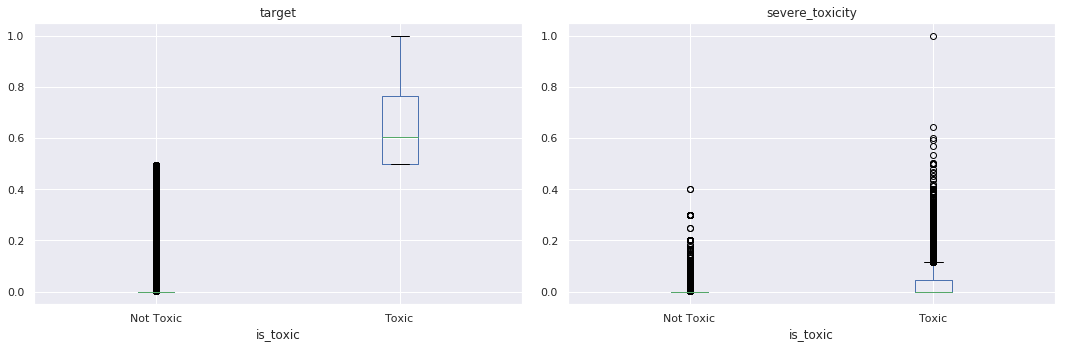

In [53]:
# draw boxplot using subplot
fig, axes = plt.subplots(1,2, figsize=(15,5))
# boxplot for target for toxic and non-toxic comments
a1 = severe_toxicity_df.boxplot('target', by="is_toxic", ax=axes.flatten()[0])
# boxplot for severe toxicity for toxic and non toxic comments
a2 = severe_toxicity_df.boxplot('severe_toxicity', by="is_toxic", ax=axes.flatten()[1])
# remove the ugly title that is generated for boxplot by default
plt.suptitle("")
# show me the plot
plt.tight_layout() 
plt.show()

The box plot above is quite interesting. On the left we have the box plot for target score grouped by toxic and non-toxic comments. On the left, we have the same box plot but for severe toxicity.

Looking at it, I want to mention a few points about the above figures:
1. Severe toxicity score is much lower than our target as expected.
2. There are some annomalies or unexpected behavior for severe toxicity. Some non-toxic comments (comments with target below .5) still have a high severe toxicity score. Why is that? Is it an error of labelling? 
3. Perhaps the comments sitting on the high end of severe toxicity score (75th percentile) can be furthered zoomed into to see if we have interesting words there to train our model.

To further understand this, lets do a word cloud for toxic comments with severe toxicity score above 75th percentile and compare to comments with severe toxicity score of 0 next.

In [54]:
# lets collect the comments with severe toxicity so we can do some further study 
comments_severe_toxicity_df = train_df.loc[:, ['severe_toxicity','comment_text'] + identities].dropna()

In [55]:
# get the 75th percentile score for severe toxicity for only toxic comments
comments_severe_toxicity_q75 = comments_severe_toxicity_df[comments_severe_toxicity_df['severe_toxicity'] > 0]['severe_toxicity'].quantile(q=.75)

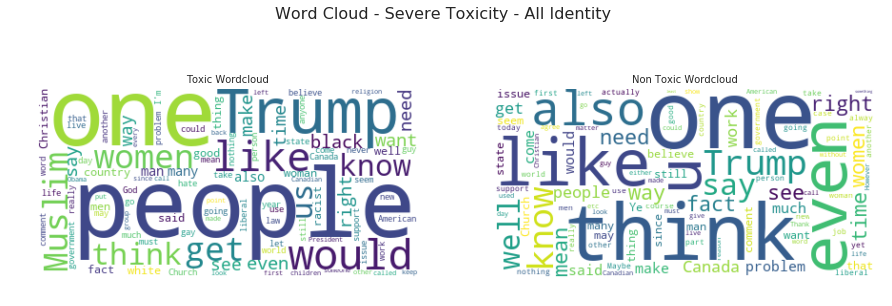

In [56]:
# lets do the word cloud!
toxic_comments = comments_severe_toxicity_df[comments_severe_toxicity_df['severe_toxicity'] >= comments_severe_toxicity_q75]['comment_text'].values
non_toxic_comments = comments_severe_toxicity_df[comments_severe_toxicity_df['severe_toxicity']==0]['comment_text'].values
toxic_comments = ' '.join(toxic_comments)
non_toxic_comments = ' '.join(non_toxic_comments)
generate_word_cloud('Severe Toxicity - All', toxic_comments, non_toxic_comments)

I find the word cloud somewhat interesting and frightening. For the toxic comments with very high severe toxicity score, we do see a lot of identities appearing as frequent words (i.e. Women, Muslim, Black). Perhaps these data can be used in isolation to learn or validate against being biased. 

## Section 9: Word Embeddings

Word embeddings algorithms are awesome! They accepts text corpus as an input and outputs a vector representation for each word. Word2Vec, proposed by Mikolov et al. in 2013, is one of the pioneering Word2Vec algorithm. So, in a nutshell, we can turn each word in the comment_text column into a point in high dimensional vector space. Words that are simiar, would sit near each other in this vector space! In this section first we will use Gensim, a popular Python library that implements Word2Vec to train our custom Word2Vec model in 64 dimensional vector space. However as this is an EDA, we want to visualize the result, and visualizing something in 64 dimensional space is impossible! Fear not, there is an amazing algorithm called t-SNE that can bring something in a higher dimension (like our Word2Vec model) into a two-dimensional plane. This is very similar to PCA, but is rather non-linear. So the spatial relation between the two words won't be lost! 

In [57]:
import multiprocessing
from nltk import word_tokenize, sent_tokenize
from gensim.models.word2vec import Word2Vec
from itertools import chain
from sklearn.manifold import TSNE

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [58]:
# first lets capture all the comments we have, training and test
comments = np.append(train_df['comment_text'].values, test_df['comment_text'].values)

In [59]:
# we will use the sentence tokenizer from the NLTK package to turn each comment into a list of sentences
comments = [sent_tokenize(comment) for comment in comments]

In [60]:
# we will flatten our list so we just have a sequence of sentences
comments = list(chain.from_iterable(comments))

In [61]:
# then we use the word tokenizer to create list of words per sentence 
# this is the format we need to transform our data before feeding word2vec model
comments = [word_tokenize(comment.lower()) for comment in comments]

In [62]:
# train our model
model = Word2Vec(sentences=comments, size=64, sg=1, window=10, min_count=5, seed=42, workers=multiprocessing.cpu_count())

The function below uses t-SNE to draw a scatter plot of words that are similar. The original function was kindly provided in this [gist](https://gist.github.com/aneesha/da9216fb8d84245f7af6edaa14f4efa9#file-display_closestwords_tsnescatterplot-ipynb).

In [63]:
def display_closestwords_tsnescatterplot(model, dim, word, topn):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word, topn)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(15,5))
    plt.scatter(x_coords, y_coords, marker='', )
    
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=14)
    
    plt.xlim(x_coords.min() - 1, x_coords.max() + 1)
    plt.ylim(y_coords.min() - 1, y_coords.max() + 1)
    plt.axis('off')
    plt.suptitle('Similar Words for Identity {}'.format(word.capitalize()), fontsize=20)
    plt.show()

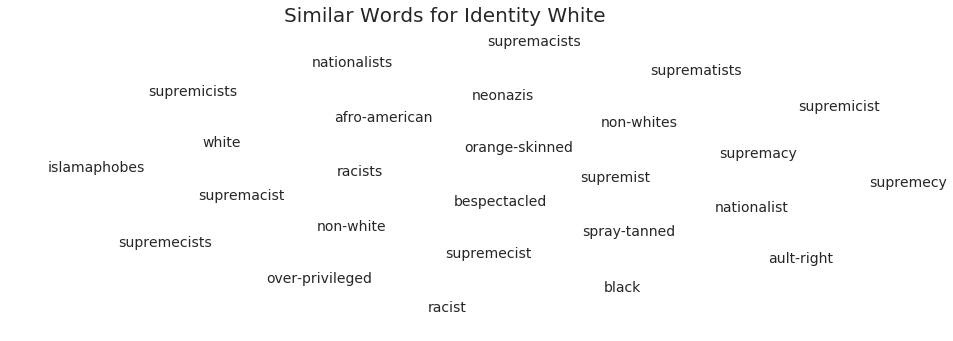

In [64]:
display_closestwords_tsnescatterplot(model, 64, 'white', 25) 

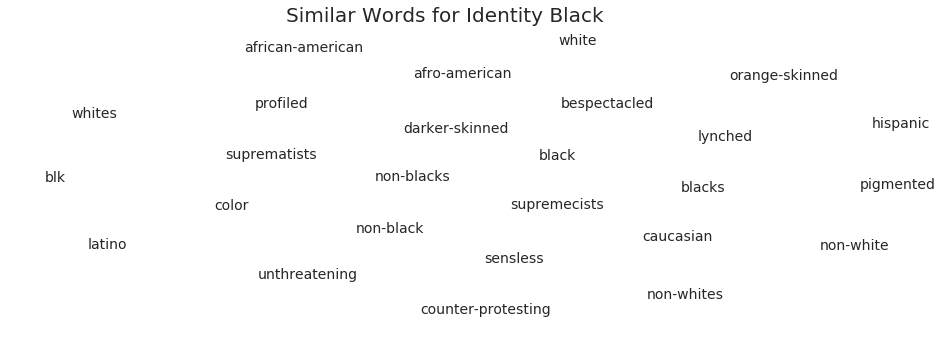

In [65]:
display_closestwords_tsnescatterplot(model, 64, 'black', 25)

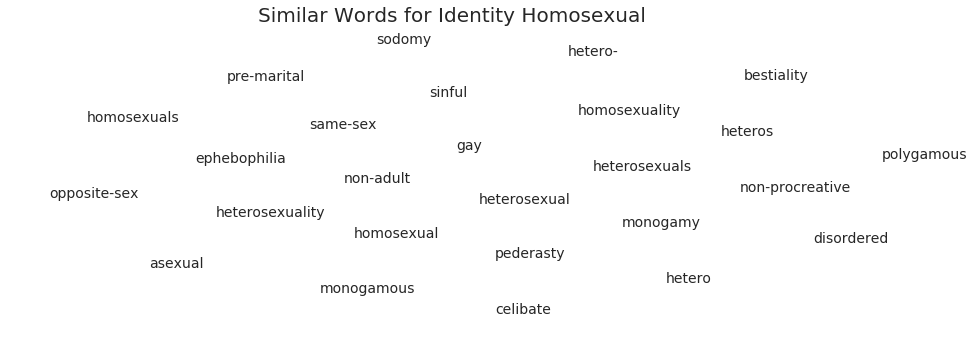

In [66]:
display_closestwords_tsnescatterplot(model, 64, 'homosexual', 25)

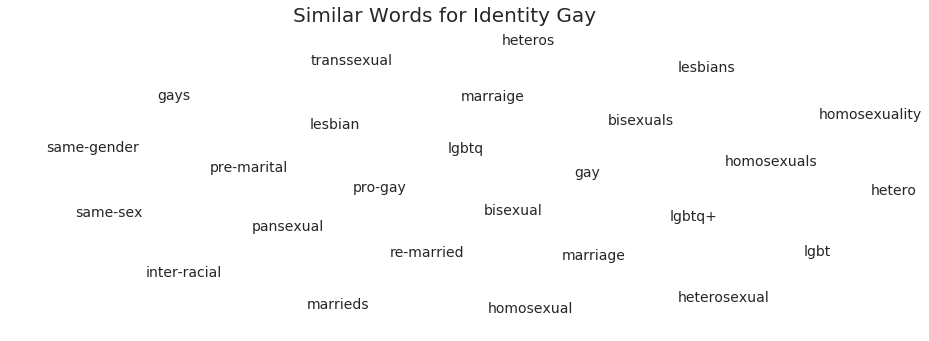

In [67]:
display_closestwords_tsnescatterplot(model, 64, 'gay', 25)

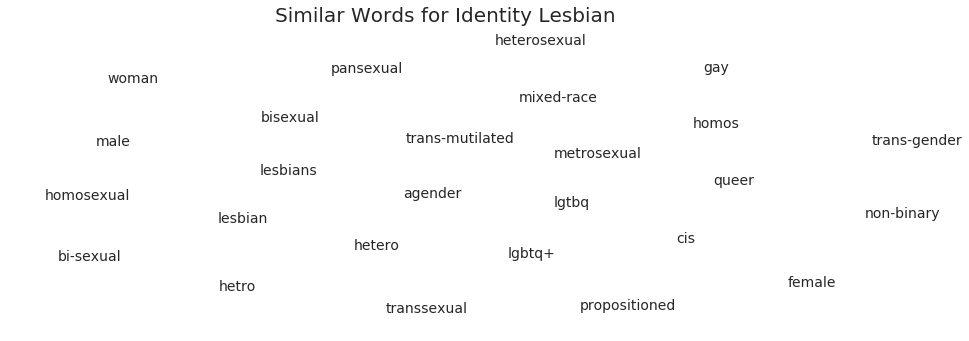

In [68]:
display_closestwords_tsnescatterplot(model, 64, 'lesbian', 25)

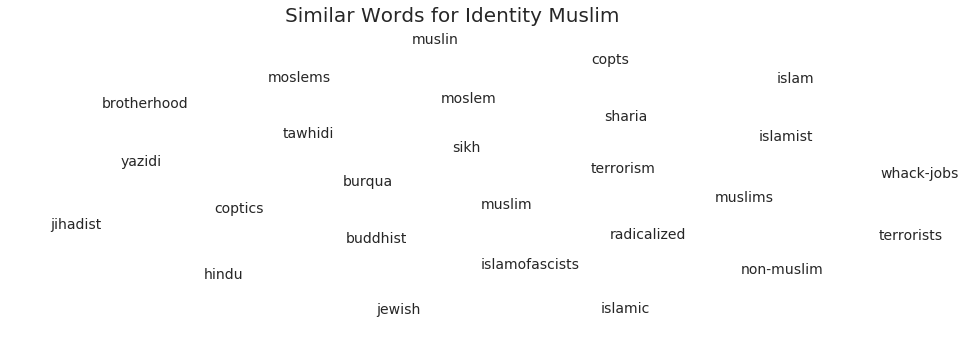

In [69]:
display_closestwords_tsnescatterplot(model, 64, 'muslim', 25)

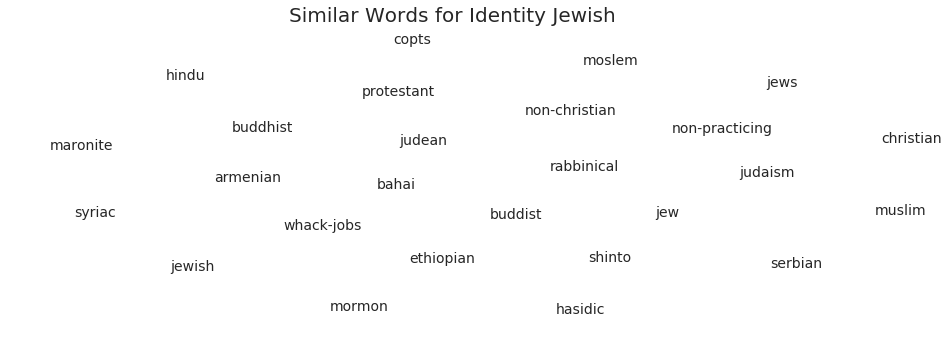

In [70]:
display_closestwords_tsnescatterplot(model, 64, 'jewish', 25)

Interesting set of words! Looking at it I have made the following observations:
* Often, two identities from similar group (race, religion) are mentioned together in the comments. For this reason, you see when we print out words similar to white we get words like black. Similarly, when we look for words similar to jewish, we see words related to muslim identity. We presumed this is the case from the heatmap, and now looking at this embedding we can only confirm the case.
* The world "white" in this dataset is really associated with many labels such as nationalists, suprematists, racists, neonazis, and so on. Which is also sad and unfortunate.
* When it comes to the word "muslim" there are a lot of variation of the way people spell it (moslem, muslin). Fortunately, a word embedding is helpful in the sense the model we create on top of this will learn to treat these variation in spelling in a similar way.

Perhaps, one can use such a embedding to use words associated with an identity and train a model to understand and ignore these words (to some extent). What do you think? Leave your observations in the comment section!